In [1]:
import os
from glob import glob

import dask
import dask.bag as db
import dask.dataframe as dd
import dask.array as da
from distributed import Client
from dask_jobqueue import SLURMCluster

import numpy as np

from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.neighbors import NearestNeighbors

import pandas as pd

import time

from IPython.display import display
import matplotlib.pyplot as plt

In [2]:
# Set LOCAL to True for single-machine execution while developing
# Set LOCAL to False for cluster execution
LOCAL = False

if LOCAL:
    # This line creates a single-machine dask client
    client = Client()
else:    
    # This line creates a SLURM cluster dask and dask client
    # Logging outputs will be stored in /scratch/{your-netid}
    
    cluster = SLURMCluster(memory='4GB', cores=8, python='/scratch/work/public/dask/bin/python', 
                               local_directory='/tmp/{}/'.format(os.environ['SLURM_JOB_USER']),
                               job_extra=['--output=/scratch/{}/slurm-%j.out'.format(os.environ['SLURM_JOB_USER'])])

    cluster.submit_command = 'slurm'
    cluster.scale(100)

    display(cluster)
    client = Client(cluster)

display(client)

Client Scheduler: tcp://10.32.33.13:40137 Dashboard: http://10.32.33.13:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
genome_cols = [str(i) for i in range(1,1129)]
user_factors_cold = dd.read_parquet('user_factors_cold.parquet', columns=['id', 'features'])
item_factors_train_genome = dd.read_parquet('item_factors_train_genome.parquet', columns=['movieId', 'target'] + genome_cols)
item_factors_test_genome = dd.read_parquet('item_factors_test_genome.parquet', columns=['movieId'] + genome_cols)

movieIds_train = item_factors_train_genome['movieId'].unique().to_dask_array().compute()
movieIds_test = item_factors_test_genome['movieId'].unique().to_dask_array().compute()

print('Number of users:', len(user_factors_cold))

Number of users: 282496


In [4]:
user_factors_cold_matrix = user_factors_cold.features\
                                                .to_dask_array()\
                                                .map_blocks(lambda x: da.array(list(x)))\
                                                .compute()
item_factors_cold_matrix = item_factors_train_genome.target\
                                                    .to_dask_array()\
                                                    .map_blocks(lambda x: da.array(list(x)))\
                                                    .compute()

print('User factors shape:', user_factors_cold_matrix.shape)
print('Item factors shape:', item_factors_cold_matrix.shape)


User factors shape: (282496, 150)
Item factors shape: (11793, 150)


In [5]:
alphas = np.array([0.1, 1, 10, 25, 50, 75, 100])

train_features_data, val_features_data = item_factors_train_genome.random_split([0.7, 0.3])

y_train = train_features_data.target\
                             .to_dask_array()\
                             .map_blocks(lambda x: da.array(list(x)))\
                             .compute()\
                             .compute()

X_train = train_features_data[genome_cols].to_dask_array().compute()

y_val = val_features_data.target\
                         .to_dask_array()\
                         .map_blocks(lambda x: da.array(list(x)))\
                         .compute()\
                         .compute()

X_val = val_features_data[genome_cols].to_dask_array().compute()

In [6]:
val_rmses = np.empty(len(alphas))
train_rmses = np.empty(len(alphas))

val_r2 = np.empty(len(alphas))
train_r2 = np.empty(len(alphas))

regressors = []
train_times = np.empty(len(alphas))
print('Tuning regressor...')
for i in range(len(alphas)):
    multi_regressor = MultiOutputRegressor(Ridge(alpha=alphas[i]))
    t0 = time.time()
    multi_regressor.fit(X_train, y_train)
    train_times[i] = time.time()-t0
    val_rmses[i] = mean_squared_error(y_val, multi_regressor.predict(X_val))
    train_rmses[i] = mean_squared_error(y_train, multi_regressor.predict(X_train))

    val_r2[i] = r2_score(y_val, multi_regressor.predict(X_val))
    train_r2[i] = r2_score(y_train, multi_regressor.predict(X_train))

    regressors.append(multi_regressor)
print('Tuning done\n\n')
print('Average training time: {} seconds'.format(np.mean(train_times)))

Tuning regressor...
Tuning done


Average training time: 39.54452092306955 seconds


Best alpha:  100.0
Training RMSE:  0.04740537801144518
Training R2:  0.17105861777448228


Validation RMSE:  0.05101992405380106
Validation R2:  0.11266309520380607


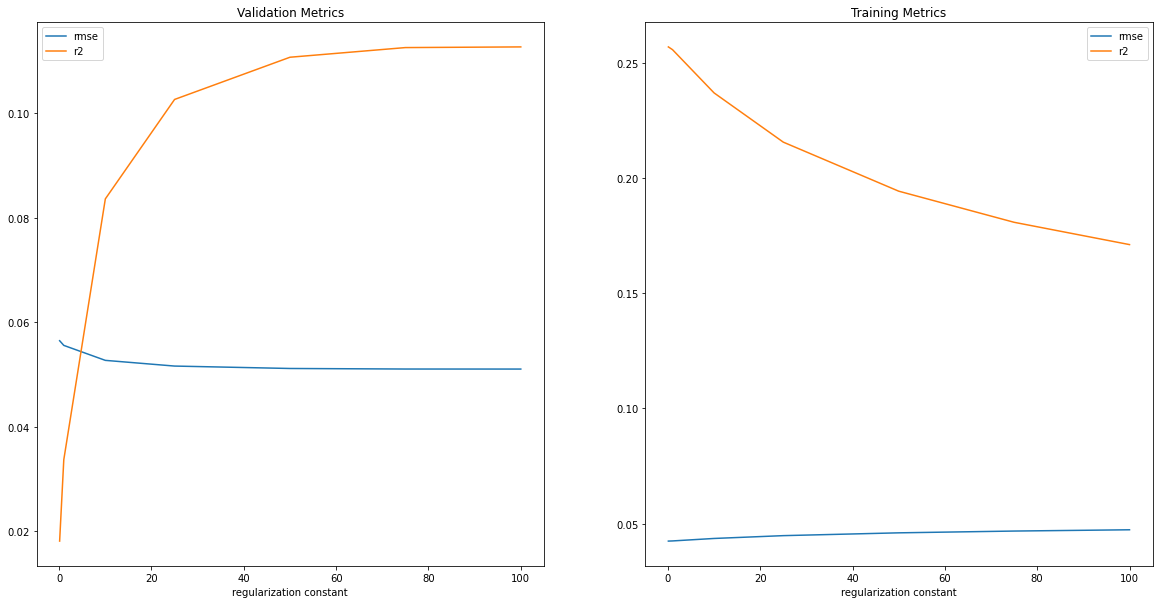

In [7]:
best_rmse = np.min(val_rmses)
best_alpha = alphas[np.argmin(val_rmses)]
best_regressor = regressors[np.argmin(val_rmses)]

print('Best alpha: ', best_alpha)
print('Training RMSE: ', mean_squared_error(y_train, best_regressor.predict(X_train)))
print('Training R2: ', r2_score(y_train, best_regressor.predict(X_train)))
print('\n')
print('Validation RMSE: ', best_rmse)
print('Validation R2: ', r2_score(y_val, best_regressor.predict(X_val)))

fig, axs = plt.subplots(1, 2, figsize=(20, 10))


axs[0].plot(alphas, val_rmses, label='rmse')
axs[0].plot(alphas, val_r2, label='r2')
axs[0].set_xlabel('regularization constant')
axs[0].set_title('Validation Metrics')
axs[0].legend()

axs[1].plot(alphas, train_rmses, label='rmse')
axs[1].plot(alphas, train_r2, label='r2')
axs[1].set_xlabel('regularization constant')
axs[1].set_title('Training Metrics')
axs[1].legend()

plt.savefig('content_model_metrics.png')

In [8]:
X_test = item_factors_test_genome[genome_cols].to_dask_array().compute()
held_out_factors_pred = da.array(best_regressor.predict(X_test))
item_factors_matrix_combined = da.vstack((item_factors_cold_matrix, held_out_factors_pred))
movieIds = da.concatenate((movieIds_train, movieIds_test)).compute()
print(movieIds)

[ 148  463  471 ...  269 1750 1947]


In [9]:
t0 = time.time()
neigh = NearestNeighbors(n_neighbors=100, radius=1000, metric='cosine')
neigh.fit(item_factors_matrix_combined)
recs_indices = da.array(neigh.kneighbors(user_factors_cold_matrix, 100, return_distance=False))
recs = recs_indices.map_blocks(lambda x: movieIds[x]).compute().tolist()
print('Recommendations generated in {} seconds'.format(time.time()-t0))

Recommendations generated in 82.47183036804199 seconds


In [10]:
userIds = user_factors_cold['id'].unique().to_dask_array().compute()

user_recs = pd.DataFrame({'userId': userIds, 'recs': recs})
user_recs.head()

,userId,recs
0,10,"[1148, 1197, 166024, 83803, 3417, 147300, 1875..."
1,20,"[1088, 2641, 3600, 7420, 26394, 7614, 6349, 22..."
2,30,"[45891, 60103, 164, 3435, 903, 8482, 7208, 852..."
3,40,"[356, 8905, 81403, 5873, 292, 3523, 7809, 1442..."
4,50,"[187595, 1610, 2237, 32203, 260, 161, 70497, 8..."


In [11]:
user_recs.to_parquet('ALS_coldStart_user_recs.parquet', index=False)